In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import ast
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping


2023-12-26 14:11:16.024085: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 14:11:16.046406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 14:11:16.046425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 14:11:16.047014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 14:11:16.050617: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# GPU 메모리 설정
# Set the GPU memory growth option
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Enable memory growth to allocate GPU memory on an as-needed basis
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Set the = activationdesired memory limit (in MB)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]
        )
    except RuntimeError as e:
        print(e)

2023-12-26 14:11:17.034427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 14:11:17.051798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 14:11:17.051918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
home_office_desks_df = pd.read_pickle("home_office_desks_df.pkl")

In [4]:
# 스타일 목록
import ast

def extract_all_styles(df, info_column='Product_Info'):
    """
    데이터프레임에서 가능한 모든 스타일을 추출합니다.

    :param df: pandas DataFrame, 'Product_Info' 열이 포함된 데이터프레임
    :param info_column: 스타일 정보가 포함된 열의 이름
    :return: 집합 형태로 모든 유니크 스타일
    """
    styles = set()
    for info in df[info_column]:
        try:
            product_info = ast.literal_eval(info)
            style = product_info.get('Style', '').lower()
            if style:
                styles.add(style)
        except ValueError:
            continue  # 파싱 에러가 발생한 경우 건너뜀
    return styles

# 모든 유니크 스타일 추출
styles = extract_all_styles(home_office_desks_df)
styles = list(styles)

In [5]:
default_resolution = 256

# 데이터 준비
def extract_style(info):
    info_dict = eval(info)
    return styles.index(info_dict['Style'].lower()) if 'Style' in info_dict and info_dict['Style'].lower() in styles else -1

# 레이블과 이미지 경로 추출
labels = []
image_paths = []
for _, row in home_office_desks_df.iterrows():
    style_index = extract_style(row['Product_Info'])
    if style_index != -1:
        labels.append(style_index)
        image_paths.append(row['img_path'])

# 레이블을 원-핫 인코딩으로 변환
labels = tf.keras.utils.to_categorical(labels, num_classes=len(styles))

# 이미지 로드 및 전처리
def process_image(image_path):
    img = load_img(image_path, target_size=(default_resolution, default_resolution))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # 정규화
    return img_array

# 이미지 로드
images = np.array([process_image(path) for path in image_paths])

# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# EfficientNet 모델 구성
input_channels = 3
se_ratio = 4
expand_ratio = 6
width_coefficient = 1.0
depth_coefficient = 1.0
default_resolution = 256
depth_divisor= 8 
dropout_rate = 0.2
drop_connect_rate = 0.2

kernel_size = [3,3,5,3,5,5,3]
num_repeat = [1,2,2,3,3,4,1]
output_filters = [16,24,40,80,112,192,320]
strides = [1,2,2,2,1,2,1]
MBConvBlock_1_True  =  [True,False,False,False,False,False,False]

def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(depth_coefficient * repeats))

def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

K = tf.keras.backend
class DropConnect(layers.Layer):
    def __init__(self, drop_connect_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, training=None):
        if training:
            keep_prob = 1.0 - self.drop_connect_rate
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += K.random_uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output
        else:
            return inputs

def SEBlock(filters,reduced_filters):
    def _block(inputs):
        x = layers.GlobalAveragePooling2D()(inputs)
        x = layers.Reshape((1,1,x.shape[1]))(x)
        x = layers.Conv2D(reduced_filters, 1, 1)(x)
        x = tfa.activations.mish(x)
        x = layers.Conv2D(filters, 1, 1)(x)
        x = layers.Activation('sigmoid')(x)
        x = layers.Multiply()([x, inputs])
        return x
    return _block

def MBConvBlock(x,kernel_size, strides,drop_connect_rate,output_channels,MBConvBlock_1_True=False):
    output_channels = round_filters(output_channels,width_coefficient,depth_divisor)
    if MBConvBlock_1_True:
        block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(x)
        block = layers.BatchNormalization()(block)
        block = tfa.activations.mish(block)
        block = SEBlock(x.shape[3],x.shape[3]/se_ratio)(block)
        block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
        block = layers.BatchNormalization()(block)
        return block

    channels = x.shape[3]
    expand_channels = channels * expand_ratio
    block = layers.Conv2D(expand_channels, (1,1), padding='same', use_bias=False)(x)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = layers.DepthwiseConv2D(kernel_size, strides,padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    block = tfa.activations.mish(block)
    block = SEBlock(expand_channels,channels/se_ratio)(block)
    block = layers.Conv2D(output_channels, (1,1), padding='same', use_bias=False)(block)
    block = layers.BatchNormalization()(block)
    if x.shape[3] == output_channels:
        block = DropConnect(drop_connect_rate)(block)
        block = layers.Add()([block, x])
    return block

def EffNet(num_classes):
    x_input = layers.Input(shape=(default_resolution,default_resolution,input_channels))    
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), (3,3), 2,padding='same', use_bias=False)(x_input)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    num_blocks_total = sum(num_repeat)
    block_num = 0
    for i in range(len(kernel_size)):
        round_num_repeat = round_repeats(num_repeat[i], depth_coefficient)
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        x = MBConvBlock(x,kernel_size[i],strides[i],drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
        block_num += 1
        if round_num_repeat > 1:
            for bidx in range(round_num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                x = MBConvBlock(x,kernel_size[i],1,drop_rate,output_filters[i],MBConvBlock_1_True = MBConvBlock_1_True[i])
                block_num += 1
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = tfa.activations.mish(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(len(styles), activation='softmax')(x)
    model = tf.keras.models.Model(inputs=x_input, outputs=x)
    return model

In [7]:
# 모델 정의 및 컴파일
model = EffNet(num_classes=len(styles))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopper], verbose=1)

# 테스트 세트에서 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

2023-12-26 14:11:45.360467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 14:11:45.360611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-26 14:11:45.360687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/100


2023-12-26 14:11:56.263342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-26 14:11:58.996781: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fabed870830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-26 14:11:58.996797: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-26 14:11:59.082945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703567519.243142   37198 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


298/298 [==============================] - 49s 78ms/step - loss: 1.7428 - accuracy: 0.6119 - val_loss: 1.5600 - val_accuracy: 0.6162
Epoch 2/100
298/298 [==============================] - 11s 35ms/step - loss: 1.4464 - accuracy: 0.6728 - val_loss: 1.5033 - val_accuracy: 0.6667
Epoch 3/100
298/298 [==============================] - 7s 25ms/step - loss: 1.3482 - accuracy: 0.6796 - val_loss: 1.3622 - val_accuracy: 0.6835
Epoch 4/100
298/298 [==============================] - 7s 25ms/step - loss: 1.2680 - accuracy: 0.6993 - val_loss: 1.1878 - val_accuracy: 0.6869
Epoch 5/100
298/298 [==============================] - 7s 25ms/step - loss: 1.2071 - accuracy: 0.7098 - val_loss: 1.3006 - val_accuracy: 0.7306
Epoch 6/100
298/298 [==============================] - 7s 25ms/step - loss: 1.1343 - accuracy: 0.7149 - val_loss: 1.2085 - val_accuracy: 0.7205
Epoch 7/100
298/298 [==============================] - 7s 25ms/step - loss: 1.0504 - accuracy: 0.7401 - val_loss: 1.2097 - val_accuracy: 0.7239
Ep

10/10 [==============================] - 1s 14ms/step


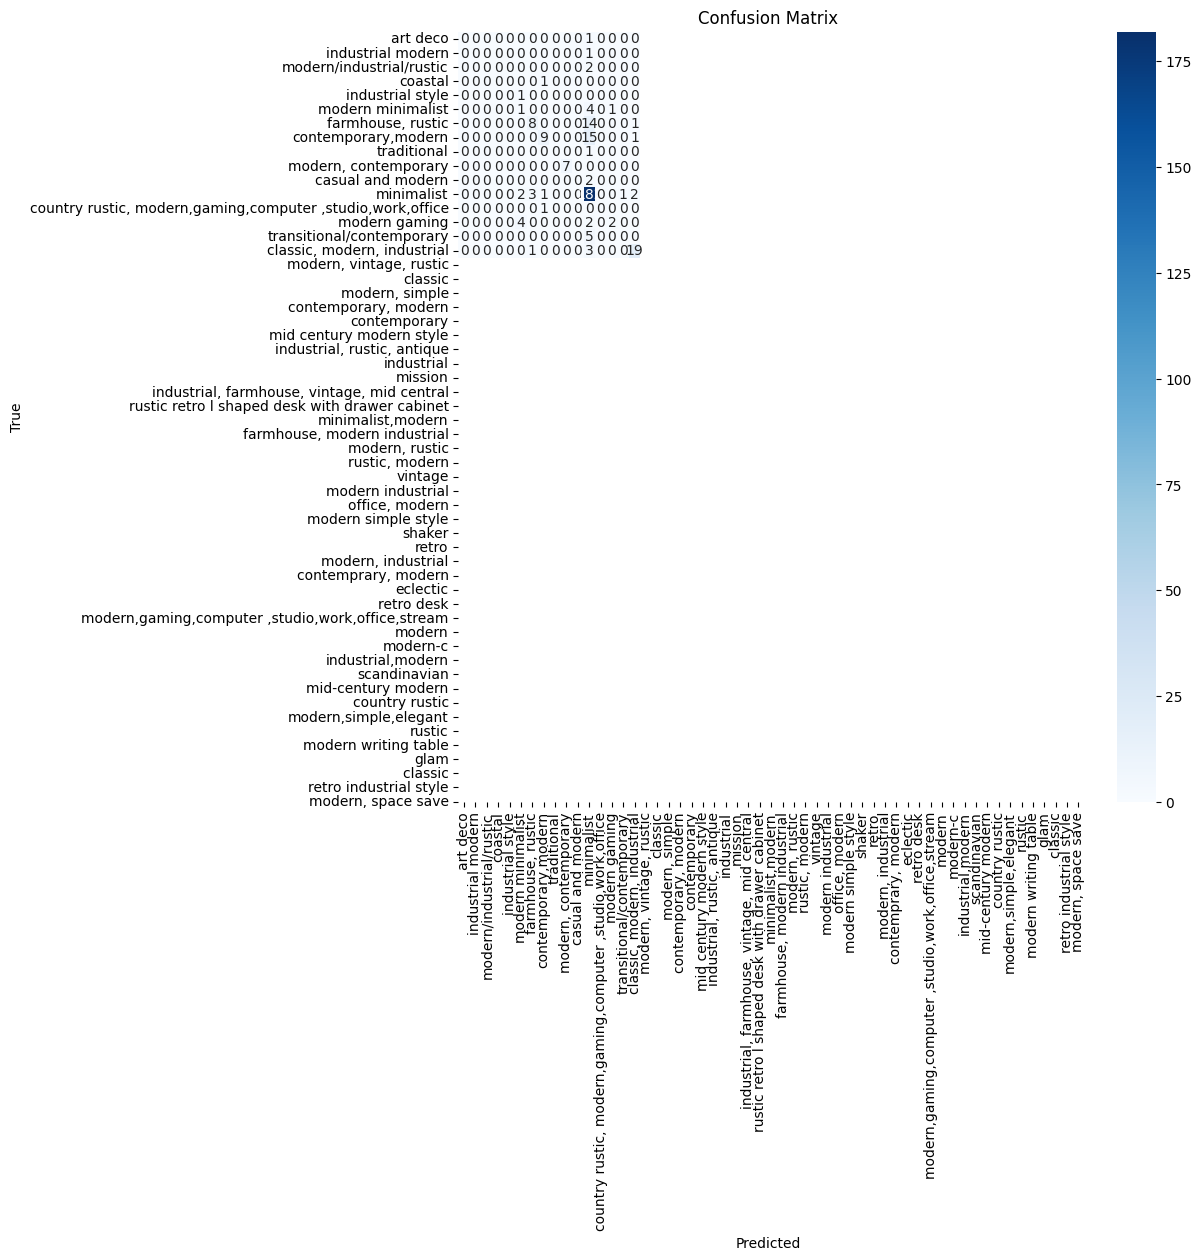

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델을 사용하여 테스트 세트에 대한 예측을 수행
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(true_classes, predicted_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=styles, yticklabels=styles)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

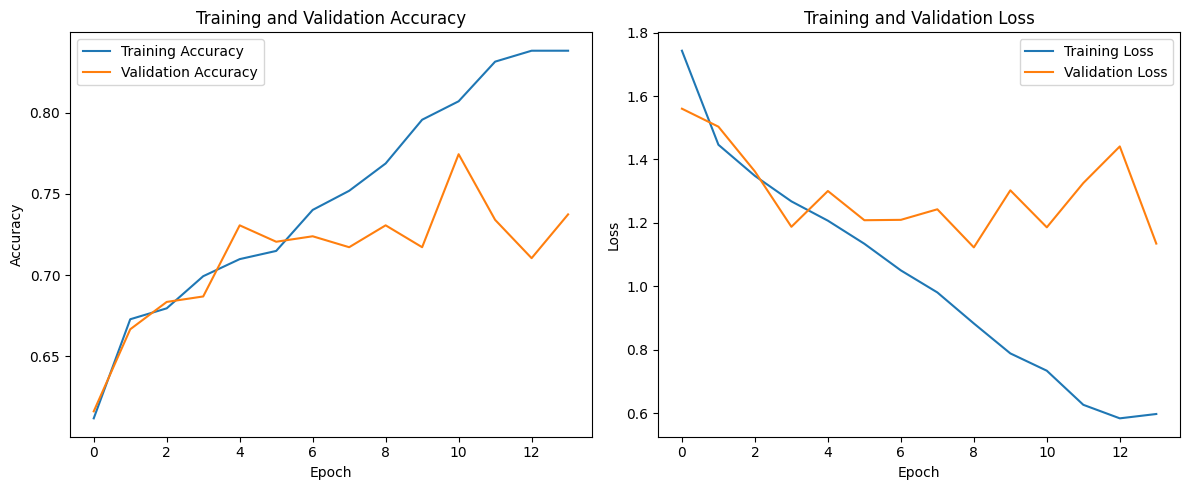

In [9]:
# 학습 및 검증 정확도 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 학습 및 검증 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 모델 저장
model_save_path = '/home/myeong/Desks_model.h5'  # .h5 확장자를 사용
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

/home/myeong/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /home/myeong/Desks_model.h5


**데이터 증강**

In [11]:
# 데이터 살피기
# 1. 유니크 추출(styles변수)
import ast

def extract_all_styles(df, info_column='Product_Info'):
    """
    데이터프레임에서 가능한 모든 스타일을 추출합니다.

    :param df: pandas DataFrame, 'Product_Info' 열이 포함된 데이터프레임
    :param info_column: 스타일 정보가 포함된 열의 이름
    :return: 집합 형태로 모든 유니크 스타일
    """
    styles = set()
    for info in df[info_column]:
        try:
            product_info = ast.literal_eval(info)
            style = product_info.get('Style', '').lower()
            if style:
                styles.add(style)
        except ValueError:
            continue  # 파싱 에러가 발생한 경우 건너뜀
    return styles

# 모든 유니크 스타일 추출
styles = extract_all_styles(home_office_desks_df)
print(styles)

{'art deco', 'industrial modern', 'modern/industrial/rustic', 'coastal', 'industrial style', 'modern minimalist', 'farmhouse, rustic', 'contemporary,modern', 'traditional', 'modern, contemporary', 'casual and modern', 'minimalist', 'country rustic, modern,gaming,computer ,studio,work,office', 'modern gaming', 'transitional/contemporary', 'classic, modern, industrial', 'modern, vintage, rustic', 'classic', 'modern, simple', 'contemporary, modern', 'contemporary', 'mid century modern style', 'industrial, rustic, antique', 'industrial', 'mission', 'industrial, farmhouse, vintage, mid central', 'rustic retro l shaped desk with drawer cabinet', 'minimalist,modern', 'farmhouse, modern industrial', 'modern, rustic', 'rustic, modern', 'vintage', 'modern industrial', 'office, modern', 'modern simple style', 'shaker', 'retro', 'modern, industrial', 'contemprary, modern', 'eclectic', 'retro desk', 'modern,gaming,computer ,studio,work,office,stream', 'modern', 'modern-c', 'industrial,modern', 'sca

In [12]:
# 2. 스타일별 개수 뽑기(style_counts변수)
# 스타일별 개수를 저장할 딕셔너리 초기화
style_counts = {style: 0 for style in styles}

# 'Product_Info' 열의 각 항목에서 스타일 추출 및 개수 계산
for info in home_office_desks_df['Product_Info']:
    try:
        product_info = ast.literal_eval(info)
        style = product_info.get('Style', '').lower()
        if style in styles:
            style_counts[style] += 1
    except ValueError:
        continue  # 파싱 에러가 발생한 경우 건너뜀

# 결과 출력
print(style_counts)

{'art deco': 4, 'industrial modern': 1, 'modern/industrial/rustic': 1, 'coastal': 1, 'industrial style': 2, 'modern minimalist': 1, 'farmhouse, rustic': 1, 'contemporary,modern': 5, 'traditional': 26, 'modern, contemporary': 4, 'casual and modern': 1, 'minimalist': 14, 'country rustic, modern,gaming,computer ,studio,work,office': 1, 'modern gaming': 2, 'transitional/contemporary': 2, 'classic, modern, industrial': 2, 'modern, vintage, rustic': 1, 'classic': 104, 'modern, simple': 1, 'contemporary, modern': 7, 'contemporary': 230, 'mid century modern style': 2, 'industrial, rustic, antique': 1, 'industrial': 242, 'mission': 3, 'industrial, farmhouse, vintage, mid central': 3, 'rustic retro l shaped desk with drawer cabinet': 1, 'minimalist,modern': 1, 'farmhouse, modern industrial': 1, 'modern, rustic': 2, 'rustic, modern': 2, 'vintage': 27, 'modern industrial': 1, 'office, modern': 3, 'modern simple style': 1, 'shaker': 1, 'retro': 10, 'modern, industrial': 1, 'contemprary, modern': 49

In [13]:
# 3. 데이터 필터링(내가 특정한 몇 개의 데이터(너무 소수의 데이터는 증강시키기 애매함))
# 이번 case의 : style_counts에서 50개 이하인 클래스 제거
filtered_classes = [style for style, count in style_counts.items() if count > 50]

# 데이터프레임에서 해당 클래스만 필터링
filtered_df = home_office_desks_df[home_office_desks_df['Style'].isin(filtered_classes)]

KeyError: 'Style'

In [ ]:
# 4. ImageDataGenerator 설정
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 설정
datagen = ImageDataGenerator(
    rotation_range=20,  # 이미지를 20도까지 회전
    width_shift_range=0.2,  # 이미지를 수평으로 최대 20%까지 이동
    height_shift_range=0.2,  # 이미지를 수직으로 최대 20%까지 이동
    shear_range=0.2,  # 이미지를 최대 20%까지 전단 변형
    zoom_range=0.2,  # 이미지를 최대 20%까지 확대/축소
    horizontal_flip=True,  # 이미지를 수평으로 뒤집기
    fill_mode='nearest'  # 증강에서 생긴 빈 공간을 인접한 픽셀로 채우기
)

In [ ]:
# 5. ImageDataGenerator으로 이미지 증강
# 단, 가장 많은 style(modern)에 대해서는 증강을 진행하지 않음
import os

# 증강 이미지를 저장할 디렉토리 생성 (있는 경우 생략)
augmented_dir = '/home/all/imgs/Desks_augmented_img'
os.makedirs(augmented_dir, exist_ok=True)

# 클래스별 샘플 수에 따라 가장 많은 데이터를 가진 클래스 찾기
max_samples_style = max(style_counts, key=style_counts.get)

# 가장 많은 데이터를 가진 클래스를 제외한 클래스별로 증강
for style in filtered_classes:
    # 가장 많은 데이터를 가진 클래스는 건너뛰기
    if style == max_samples_style:
        continue

    style_df = filtered_df[filtered_df['Style'] == style]
    style_dir = os.path.join(augmented_dir, style)
    os.makedirs(style_dir, exist_ok=True)
    
    for index, row in style_df.iterrows():
        img = load_img(row['img_path'])  # 이미지 로드
        img = img_to_array(img)  # NumPy 배열로 변환
        img = img.reshape((1,) + img.shape)  # 차원 추가

        # 이미지 증강 및 저장
        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=style_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 20:  # 각 이미지당 20개의 증강 이미지 생성
                break